In [6]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import sys
print(sys.version)
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image

from tensorboardX import SummaryWriter
from tqdm import tqdm
from copy import deepcopy


from utils import *
from models import *
from fid_score import *
from inception_score import *

from real_imgs import *

3.9.5 (v3.9.5:0a7dcbdb13, May  3 2021, 13:17:02) 
[Clang 6.0 (clang-600.0.57)]
['/Users/ryomacmini/work/codes/MNIST_Calculator/calculator', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/lib/python', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages', '/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/IPython/extensions', '/Users/ryomacmini/.ipython']


In [9]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=1,shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

print(type(transform))
print(type(trainset))
print(type(testset))
print(transform)
print(trainset)
print(testset)

trainset_not_transform = torchvision.datasets.MNIST(root='./data', train=True,download=True)
testset_not_transform = torchvision.datasets.MNIST(root='./data', train=False, download=True)
print(type(trainset_not_transform))
print(type(testset_not_transform))


<class 'torchvision.transforms.transforms.Compose'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
Compose(
    ToTensor()
)
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>


/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Label: tensor(0)


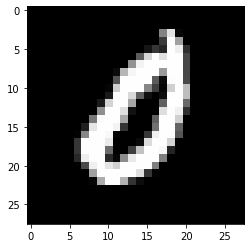

In [27]:
data_iter = iter(trainloader)
images, labels = data_iter.next()

# matplotlibで1つ目のデータを可視化してみる
npimg = images[0].numpy()
npimg = npimg.reshape((28, 28))
plt.imshow(npimg, cmap='gray')
print('Label:', labels[0])

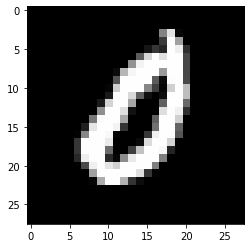

In [41]:
for i,labels in enumerate(trainset):
    if i < 10:
        # print(images)
        npimg = images[0].numpy()
        npimg = npimg.reshape((28, 28))
        plt.imshow(npimg, cmap='gray')
        # plt.imshow(labels[0])
        # plt.show()
        # print(labels[1])
    if i > 10:
        break

In [1]:
trainset_not_transform[0]

NameError: name 'trainset_not_transform' is not defined

i:0
<class 'torch.Tensor'>
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

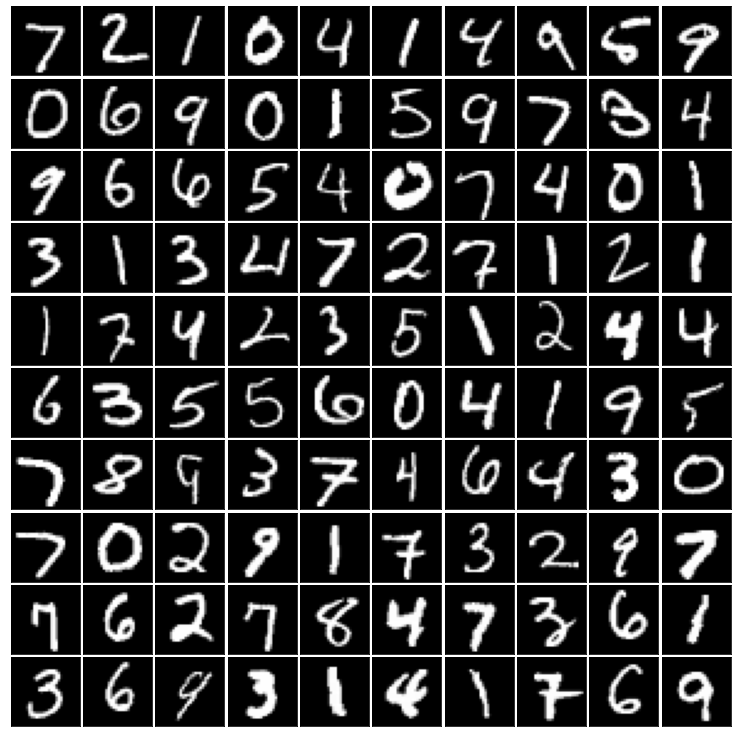

In [12]:
H = 10
W = 10
fig = plt.figure(figsize=(H, W))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1.0, hspace=0.05, wspace=0.05)

for i, (images, labels) in enumerate(testloader, 0):

  n = images[0]*255
  #n = images[0]
  #print(n)
  
  numpy_array = n.numpy()

  ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
  ax.imshow(numpy_array.reshape((28, 28)), cmap='gray')

  if i==0:
    print("i:{}".format(i))
    print(type(images))
    print(images.size())
    print(images[0].size())
    print(images[0])
    print(numpy_array)

    print(type(labels))
    print(labels)
    print(labels.size())

  if i >= 99:
    break